# Violin Plots Analysis

This Jupyter Notebook combines the functionality of various Python scripts related to generating violin plots. It includes code for data extraction from a SQLite database, data processing, and visualization using libraries such as pandas, seaborn, and matplotlib.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

# Set style for scientific plotting
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper")

In [3]:
# Connect to SQLite database
conn = sqlite3.connect('../../../db/MasterDatabase.db')

# Read the solubility data
query = """
SELECT COALESCE(s1.molecular_name, 'Unknown') as solvent_1, 
    COALESCE(s2.molecular_name, 'Unknown') as solvent_2, 
    sol.solubility_g_g * 100 as solubility_g_100g
FROM solubility sol
LEFT JOIN solvents s1 ON sol.solvent_1 = s1.pubchem_id
LEFT JOIN solvents s2 ON sol.solvent_2 = s2.pubchem_id
WHERE sol.solubility_g_g IS NOT NULL
"""
df = pd.read_sql_query(query, conn, dtype={'solubility_g_100g': np.float64})

def print_data_summary(df, name):
    print(f"\n=== {name} Data Summary ===")
    print(f"Min solubility: {df['solubility_g_100g'].min():.2e}")
    print(f"Max solubility: {df['solubility_g_100g'].max():.2e}")
    print(f"Number of records: {len(df)}")

print_data_summary(df, "Split by Solvent Dataset")


=== Split by Solvent Dataset Data Summary ===
Min solubility: 0.00e+00
Max solubility: 1.96e+06
Number of records: 45127


c:\Users\herbi\Documents\GitHub\Solvent_Swap_Optimisation\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\herbi\AppData\Local\Temp\ipykernel_20288\2958521331.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='solvent', y='log_solubility_g_100g', data=df_cleaned_all, ax=ax, inner='quartile', scale='width', color='lightgray')
C:\Users\herbi\AppData\Local\Temp\ipykernel_20288\2958521331.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in ax.get_yticks()])
C:\Users\herbi\AppData\Local\Temp\ipykernel_20288\2958521331.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks()

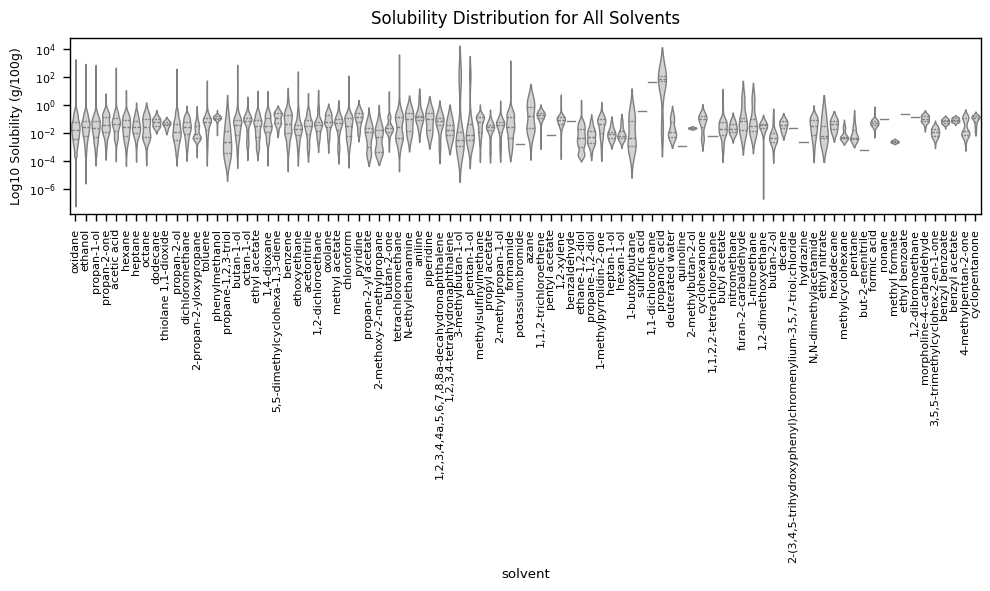

In [5]:
# Ensure the precision is float64
df['solubility_g_100g'] = df['solubility_g_100g'].astype(np.float64)

# Combine solvent_1 and solvent_2 into a single column for easier processing
df_melted = pd.melt(df, id_vars=['solubility_g_100g'], value_vars=['solvent_1', 'solvent_2'], var_name='solvent_type', value_name='solvent')

# Create violin plot for solubility distribution
fig, ax = plt.subplots(figsize=(10, 6))
df_melted['log_solubility_g_100g'] = np.log10(df_melted['solubility_g_100g'].astype(np.float64))
df_cleaned_all = df_melted[df_melted['solvent'] != 'Unknown']
sns.violinplot(x='solvent', y='log_solubility_g_100g', data=df_cleaned_all, ax=ax, inner='quartile', scale='width', color='lightgray')
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in ax.get_yticks()])
ax.set_ylabel('Log10 Solubility (g/100g)', fontsize=9)
ax.set_title('Solubility Distribution for All Solvents', fontsize=12, pad=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig('solubility_violin_all_solvents.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\herbi\AppData\Local\Temp\ipykernel_20288\1466019888.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(y='iqr_log_solubility', data=df_stats, ax=ax, inner='quartile', scale='width', color='lightgray')


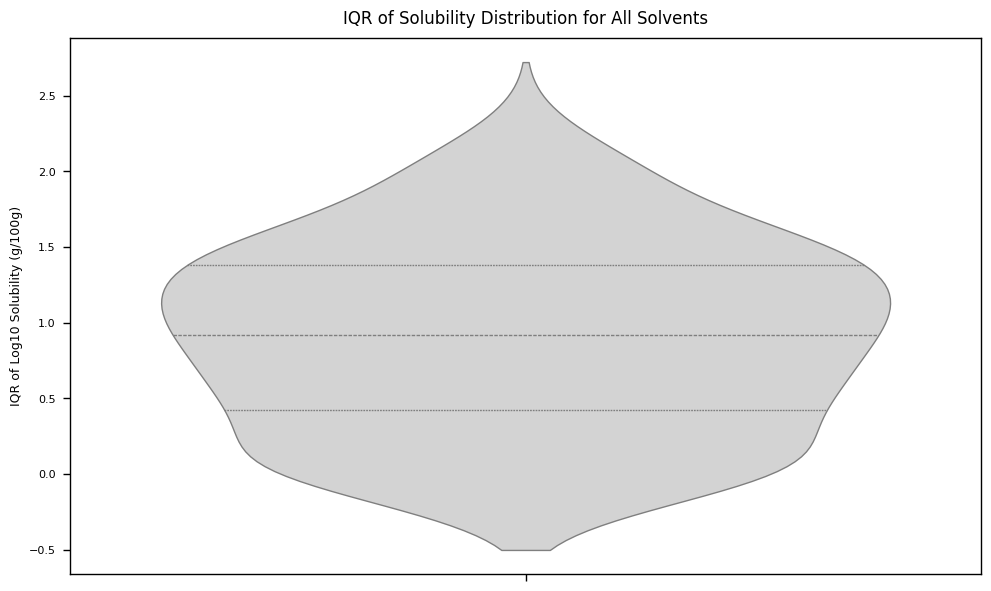

In [7]:
# Create violin plot for IQR
df_stats = df_cleaned_all.groupby('solvent')['log_solubility_g_100g'].agg(['var', 'std', lambda x: np.percentile(x, 75) - np.percentile(x, 25)]).reset_index()
df_stats.columns = ['solvent', 'variance_log_solubility', 'std_log_solubility', 'iqr_log_solubility']
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(y='iqr_log_solubility', data=df_stats, ax=ax, inner='quartile', scale='width', color='lightgray')
ax.set_ylabel('IQR of Log10 Solubility (g/100g)', fontsize=9)
ax.set_title('IQR of Solubility Distribution for All Solvents', fontsize=12, pad=10)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.savefig('solubility_iqr_violin_all_solvents.png', dpi=300, bbox_inches='tight')
plt.show()

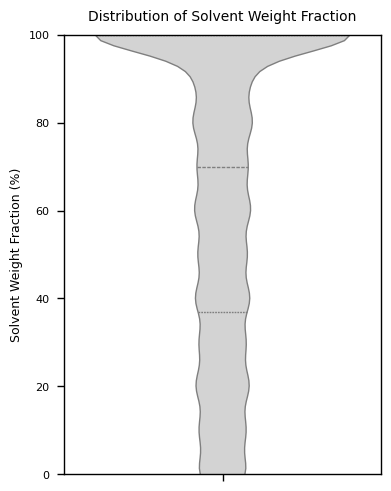

In [8]:
# Create violin plot for solvent weight fraction
query_weight_fraction = """
SELECT solvent_1_weight_fraction * 100 as solvent_weight_fraction
FROM solubility
"""
df_weight = pd.read_sql_query(query_weight_fraction, conn, dtype={'solvent_weight_fraction': np.float64})
df_weight['solvent_weight_fraction'] = df_weight['solvent_weight_fraction'].astype(np.float64)
fig, ax = plt.subplots(figsize=(4, 5))
sns.violinplot(y=df_weight['solvent_weight_fraction'], ax=ax, color='lightgray', inner='quartile')
plt.ylim(0,100)
plt.title('Distribution of Solvent Weight Fraction', fontsize=10, pad=10)
plt.ylabel('Solvent Weight Fraction (%)', fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.savefig('solvent_weight_violin.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Close the database connection
conn.close()


=== Complete Dataset Data Summary ===
Min solubility: 0.00e+00
Max solubility: 1.96e+06
Number of records: 45127


c:\Users\herbi\Documents\GitHub\Solvent_Swap_Optimisation\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\herbi\AppData\Local\Temp\ipykernel_20288\740120089.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in ax.get_yticks()])


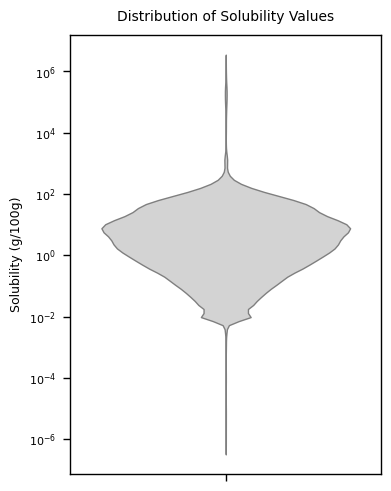

In [ ]:
# Add this as a new cell after the first code cell

# Connect to SQLite database
conn = sqlite3.connect('../../../db/MasterDatabase.db')

# Read the solubility data
query = """
SELECT solubility_g_g * 100 as solubility_g_100g
FROM solubility
WHERE solubility_g_g IS NOT NULL
"""
df = pd.read_sql_query(query, conn, dtype={'solubility_g_100g': np.float64})

def print_data_summary(df, name):
    print(f"\n=== {name} Data Summary ===")
    print(f"Min solubility: {df['solubility_g_100g'].min():.2e}")
    print(f"Max solubility: {df['solubility_g_100g'].max():.2e}")
    print(f"Number of records: {len(df)}")

print_data_summary(df, "Complete Dataset")

# Ensure the precision is float64
df['solubility_g_100g'] = df['solubility_g_100g'].astype(np.float64)

# Create figure with publication-appropriate size
fig, ax = plt.subplots(figsize=(4, 5))

# Apply log scale while maintaining float64 precision
df['log_solubility_g_100g'] = np.log10(df['solubility_g_100g'].astype(np.float64))
sns.violinplot(y=df['log_solubility_g_100g'], ax=ax, inner='quartile', color='lightgray')

# Customize y-axis to reflect log scale with different power notation
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in ax.get_yticks()])
plt.ylabel('Log10 Solubility (g/100g)', fontsize=9)

# Customize the plot with appropriate font sizes
plt.title('Distribution of Solubility Values', fontsize=10, pad=10)
plt.ylabel('Solubility (g/100g)', fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)

# Adjust layout to be tight
plt.tight_layout()

# Save the plot
plt.savefig('solubility_violin.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


=== Temperature Dataset Data Summary ===
Min temperature: 2.00e+02
Max temperature: 8.00e+02
Number of records: 45127


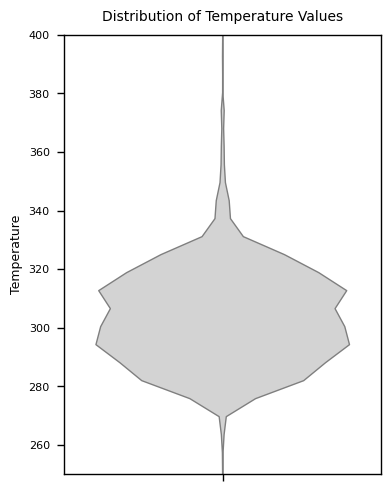

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('../../../db/MasterDatabase.db')

# Read the temperature data
query_temperature = """
SELECT temperature
FROM solubility
WHERE temperature IS NOT NULL
"""
df_temperature = pd.read_sql_query(query_temperature, conn, dtype={'temperature': np.float64})

def print_data_summary(df, name):
    print(f"\n=== {name} Data Summary ===")
    print(f"Min temperature: {df['temperature'].min():.2e}")
    print(f"Max temperature: {df['temperature'].max():.2e}")
    print(f"Number of records: {len(df)}")

print_data_summary(df_temperature, "Temperature Dataset")

# Ensure the precision is float64
df_temperature['temperature'] = df_temperature['temperature'].astype(np.float64)

# Create figure with publication-appropriate size
fig, ax = plt.subplots(figsize=(4, 5))

# Create violin plot without log scale
sns.violinplot(y=df_temperature['temperature'], ax=ax, inner='quartile', color='lightgray')
plt.ylim(250, 400)

# Customize the plot with appropriate font sizes
plt.title('Distribution of Temperature Values', fontsize=10, pad=10)
plt.ylabel('Temperature', fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)

# Adjust layout to be tight
plt.tight_layout()

# Save the plot
plt.savefig('temperature_violin.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
